In [13]:
###########################################
# This file contains the following:
# 1. Linear Transformer Model
# 2. Function for clipping gradient
# 3. Function for generating random data
#
# The notation for linear attention follows
# the paper at https://arxiv.org/pdf/2306.00297.pdf
###########################################


import torch
from torch import nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definition of a single linear attention unit for linear-regression data
# P is the value matrix
# Q is the product of key,query matrices
# the dimensions of the input are
# B: batch-size of prompts
# N: context length (excluding query)
# d: covariate dimension
# P,Q are d x d matrices
# Z is a B x (N+1) + (d+1) matrix
# Output is also B x (N+1) + (d+1)

# For linear attention, activation = None
# For standard attention, activation(x) = torch.nn.functional.softmax(x, dim = 2)
# For ReLU attention, activation(x) = torch.nn.relu(x)
def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    P_full =  torch.cat([P,torch.zeros(1,d).to(device)],dim=0)
    P_full =  torch.cat([P_full,torch.zeros(d+1,1).to(device)],dim=1)
    P_full[d,d] = 1
    Q_full = torch.cat([Q, torch.zeros(1,d).to(device)],dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1,1).to(device)],dim=1)
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q_full,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P_full,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N


# The Linear Transformer module
# n_layer denotes the number of layers
# n_head denotes the number of heads. In most of our experiments, n_head = 1
# d denotes the dimension of covariates
# var denotes the variance of initialization. It needs to be sufficiently small, but exact value is not important
# allparam: contains all the parameters, has dimension n_layer x n_head x 2 x d x d
# For example
# - P matrix at layer i, head j is allparam[i,j,0,:,:]
# - Q matrix at layer i, head j is allparam[i,j,1,:,:]
# Z is a (n_head x minibatch size) x (N+1) + (d+1) matrix
# If run_mode = 0 then training. If run_mode = 1 then in-context learning.
class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, d, var, run_mode):
        super(Transformer_F, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))

        # Initialize alpha, beta, and gamma with shape (n_layer, n_head)
        self.alpha = nn.Parameter(torch.ones(n_layer, n_head), requires_grad=False)
        self.beta = nn.Parameter(torch.zeros(n_layer, n_head), requires_grad=False)
        self.gamma = nn.Parameter(torch.ones(n_layer, n_head), requires_grad=False)

        # Initialize the parameters for allparam
        with torch.no_grad():
            self.allparam.normal_(0, var)

        self.n_layer = n_layer
        self.n_head = n_head
        self.run_mode = run_mode

    def forward(self, Z):
        # Toggle beta, alpha, and gamma training based on run_mode
        self.alpha.requires_grad = (self.run_mode == 1)
        self.beta.requires_grad = (self.run_mode == 1)
        self.gamma.requires_grad = (self.run_mode == 1)

        # Extract B, N, and d values
        B, N, d = Z.shape[0], Z.shape[1] - 1, Z.shape[2] - 1

        # Enforce the sparsity condition before processing on P
        self.zero_p()
        # Enforce the scalar multiple of identity condition on Q
        self.identity_q()

        # Split Z into minibatches based on n_head
        minibatch_size = B // self.n_head
        minibatches = list(torch.split(Z, minibatch_size, dim=0))  # Convert tuple to list

        # Initialize R as a list of zero tensors corresponding to minibatches
        R = [torch.zeros_like(minibatch) for minibatch in minibatches]

        for i in range(self.n_layer):
            # For each layer, process each head
            for j in range(self.n_head):
                Zij = minibatches[j]
                Pij = self.allparam[i, j, 0, :, :]
                Qij = self.allparam[i, j, 1, :, :]
                attention_ij = attention(Pij, Qij, Zij)

                # Use per-head alpha, beta, and gamma for each layer and head
                if self.run_mode == 0:
                    R[j] = attention_ij * self.gamma[i, j]  # No accumulation in run_mode 0
                else:
                    R[j] = R[j] * self.beta[i, j] + attention_ij * self.gamma[i, j]  # Accumulate in run_mode 1

                # Update minibatches with R and per-head alpha scaling
                minibatches[j] = Zij + R[j] * self.alpha[i, j]

            # Concatenate minibatches along the batch dimension after processing all heads in this layer
            Z = torch.cat(minibatches, dim=0)

        return Z

    #enforces top-left-dxd-block sparsity on p
    def zero_p(self):
        for i in range(self.n_layer):
            for j in range(self.n_head):
                with torch.no_grad():
                    self.allparam[i,j,0,:,:].zero_()

    def identity_q(self):
        with torch.no_grad():  # Disable gradient tracking
            for i in range(self.n_layer):
                for j in range(self.n_head):
                    Qij = self.allparam[i,j,1,:,:]

                    # Zero out all off-diagonal elements
                    off_diag_mask = ~torch.eye(Qij.size(-1), dtype=torch.bool, device=Qij.device)
                    Qij.masked_fill_(off_diag_mask, 0)

                    # Set diagonal elements to the average of the original diagonal elements
                    diag_elements = Qij.diag()
                    diag_mean = diag_elements.mean()
                    Qij.fill_diagonal_(diag_mean)

                    # Safely copy the modified tensor back to allparam
                    self.allparam[i,j,1,:,:].copy_(Qij)

# evaluate the loss of model, given data (Z,y)
def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean()
    return loss

# generate random data for linear regression
# mode: distribution of samples to generate. Currently supports 'normal', 'gamma', 'sphere'
# N: number of context examples
# d: dimension of covariates
# For gamma distribution:
# - shape_k: shape parameter of gamma distribution (unused otherwise)
# - scale parameter: hard coded so that when shape_k = 5/2 and d=5, the generated data is standard normal
def generate_data(mode='normal',N=20,d=1,B=1000,shape_k=0.1, U=None, D=None):
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B,1,d).normal_(0, 1).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W= torch.FloatTensor(B, d).normal_(0,1).to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())

    if mode =='sphere':
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
    elif mode == 'gamma':
        # random gamma scaling for X
        gamma_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,N])
        gamma_scales = torch.Tensor(gamma_scales).to(device)
        gamma_scales = gamma_scales.sqrt()
        # random gamma scaling for X_test
        gamma_test_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,1])
        gamma_test_scales = torch.Tensor(gamma_test_scales).to(device)
        gamma_test_scales = gamma_test_scales.sqrt()
        # normalize to unit norm
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
        # scale by gamma
        X.mul_(gamma_scales[:,:,None])
        X_test.mul_(gamma_test_scales[:,:,None])
    elif mode =='normal':
        assert True
    elif mode == 'relu':
        return generate_data_relu(N=N, d=d, B=B, hidden_dim=d)
    elif mode == 'mlp':
        generate_data_mlp(N=N, d=d, B=B, hidden_dim=d)
    else:
        assert False

    if U is not None:
        X = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))
        X_test = torch.einsum('ij, jk, BNk -> BNi', (U,D,X_test))

    y = torch.einsum('bi,bni->bn', (W, X)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test)).squeeze(1)
    X_comb= torch.cat([X,X_test],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)
    return Z.to(device),y_test.to(device)

def generate_data_inplace(Z, U=None, D=None):


    B = Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    X = Z[:,:,0:-1]
    X.normal_(0, 1).to(device)
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())
        Z[:,:,0:-1] = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))

    Z[:,:,-1] = torch.einsum('bi,bni->bn', (W, Z[:,:,0:-1])) #y update
    y_test = Z[:,-1,-1].detach().clone()
    Z[:,-1,-1].zero_()
    return Z.to(device),y_test.to(device)

def generate_data_sine(N=10, B=1000):
    # Sample amplitude a and phase p for each task
    a = torch.FloatTensor(B).uniform_(0.1, 5).to(device)
    p = torch.FloatTensor(B).uniform_(0, math.pi).to(device)

    X = torch.FloatTensor(B, N).uniform_(-5, 5).to(device)

    Y = a.unsqueeze(1) * torch.sin(p.unsqueeze(1) + X)

    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    return X, Y

def generate_data_relu(mode='normal', N=20, d=1, B=1000, shape_k=0.1, U=None, D=None, hidden_dim=100):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    # Define a 1-hidden layer ReLU network
    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    ).to(device)
    model[0].weight.data.normal_(0, 0.1)
    model[2].weight.data.normal_(0, 0.1)

    # Generate y values using the ReLU network
    y = model(X.view(-1, d)).view(B, N, 1)
    y_test = model(X_test.view(-1, d)).view(B, 1).squeeze(1)

    y_zero = torch.zeros(B, 1, 1).to(device)
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)

    return Z, y_test

def generate_data_mlp(N=20, d=1, B=1000, hidden_dim=100):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    # Define a 1-hidden layer ReLU network
    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, d)
    ).to(device)
    model[0].weight.data.normal_(0, 1)
    model[2].weight.data.normal_(0, 1)

    X_MLP = model(X.view(-1, d)).view(B, N, d)
    X_test_MLP = model(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).to(device)
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X_MLP,X_test_MLP],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test

In [1]:
!cp /content/linear_transformer.py /content/

cp: '/content/linear_transformer.py' and '/content/linear_transformer.py' are the same file


In [2]:
import linear_transformer

In [ ]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
from torch.nn.functional import relu
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import numpy as np
import gc
from pylab import *
import os
import random
import json
import pandas as pd
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import sys
import matplotlib.pyplot as plt
import time

from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

np.set_printoptions(precision = 4, suppress = True)
torch.set_printoptions(precision=2)
device = torch.device("cpu")

In [ ]:
# Set Hyperparameters

# Fixed
n_head = 1
d = 5
B = 1000
var = 0.05
shape_k = 0.1

# Number of Iterations to run
max_iters = 1000
hist_stride = 1
stride = 50

# We vary the following parameters
n_layer = 3
mode = 'normal'
N = 20
seeds = [0,1,2,3,4,5]
algos = ['sgd','adam']
lrs = [0.02]

import random

# Generate a 3-digit random number
random_number = random.randint(100, 999)

In [ ]:
# Pipe output to log file
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
f = open(log_dir + '/train.log', "a", 1)
sys.stdout = f

# Update the filename_format to include the random_number
filename_format = log_dir + f'/train_layer{{}}_N{{}}_{{}}_{{}}_{{}}_lr{{}}_sd{{}}_rn{{}}.pth'

In [ ]:
# one-step update of (non-)clipping algotirthm
def clip_and_step(allparam, optimizer, toclip, clip_threshold = 1.):
    grad_all = allparam.grad
    grad_p = grad_all
    norm_p = grad_p.norm()
    if toclip and norm_p > clip_threshold:
            grad_all.mul_(clip_threshold/norm_p)
    optimizer.step()
    return norm_p.item()

In [ ]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train linear transformer

for alg in algos:
    for toclip in [True]:  # True means with clipping, False means without clipping
        for lr in lrs:
            for sd in seeds:
                filename = filename_format.format(n_layer, N, mode, alg, toclip, lr, sd, random_number)
                print(filename)
                np.random.seed(sd)
                torch.manual_seed(sd)
                hist_list = list()

                # Initialize model parameter
                model = Transformer_F(n_layer, n_head, d, var, 0)
                model.to(device)  # Move model to the correct device

                # Create optimizer
                if alg == 'sgd':
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0)
                elif alg == 'adam':
                    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.9), weight_decay=0)
                else:
                    assert False

                for t in range(max_iters):
                    start = time.time()
                    # Save model parameters
                    if t % hist_stride == 0:
                        hist_list.append(model.allparam.clone().detach())

                    # Generate a new batch of training set
                    Z, y = generate_data(mode, N, d, B, shape_k)
                    Z = Z.to(device)  # Move data to the correct device
                    y = y.to(device)  # Move data to the correct device

                    loss = in_context_loss(model, Z, y)
                    loss_value = loss.item()
                    loss.backward()

                    if mode == 'sphere':
                        clip_threshold = 0.1
                    else:
                        clip_threshold = 1.0

                    # Take optimizer step
                    norms = clip_and_step(model.allparam, optimizer, toclip, clip_threshold)
                    optimizer.zero_grad()

                    end = time.time()
                    if t % 100 == 0 or t < 5:
                        print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t, loss_value, end-start, norms))

                torch.save({'hist_list': hist_list}, filename)


In [ ]:
log_dir = 'log'
loss_plots = {}

for sd in seeds:
    for (alg, toclip, lr) in [('sgd', True, 0.02),('adam', True, 0.02)]:
        filename = log_dir + f'/train_layer{{}}_N{{}}_{{}}_{{}}_{{}}_lr{{}}_sd{{}}_rn{{}}.pth'.format(n_layer, N, mode, alg, toclip, lr, sd, random_number)
        loaded_dict = torch.load(filename)
        hist_list = loaded_dict['hist_list']

        np.random.seed(99)
        torch.manual_seed(99)
        Z, y = generate_data(mode,N,d,B,shape_k)
        Z = Z.to(device)
        y = y.to(device)

        model = Transformer_F(n_layer, n_head, d, var, 0)
        model = model.to(device)

        test_losses = torch.zeros(max_iters//stride)

        for t in range(0,max_iters,stride):
            allparam_loaded = hist_list[t]
            with torch.no_grad():
                model.allparam.copy_(allparam_loaded)
            test_loss = in_context_loss(model, Z, y)
            test_losses[t//stride] = test_loss.item()

        loss_plots[(alg, toclip, lr, sd, random_number)] = test_losses

<ipython-input-9-f4da55d50231>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load(filename)


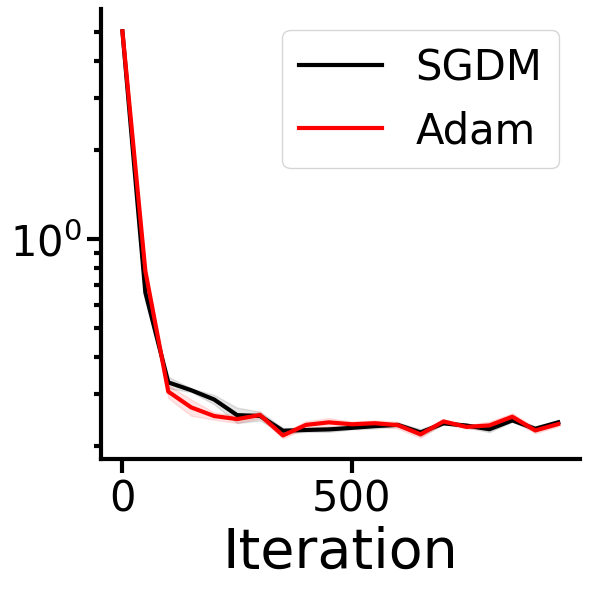

In [ ]:
fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (6, 6))

for (alg, toclip, lr) in [('sgd', True, 0.02),('adam', True, 0.02)]:
    losses = torch.zeros(len(seeds), int(max_iters/stride))
    for idx, sd in enumerate(seeds):
        losses[idx] = loss_plots[(alg, toclip, lr, sd, random_number)]
    losses_mean = torch.mean(losses, axis=0)
    losses_std = torch.std(losses, axis=0)
    if alg == 'sgd':
        ax.plot(range(0,max_iters,stride), losses_mean, color = 'black', lw = 3,label='SGDM')
        ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std/4, losses_mean+losses_std/4, color = 'black', alpha = 0.1)
    elif alg == 'adam':
        ax.plot(range(0,max_iters,stride), losses_mean, color = 'red', lw = 3, label='Adam')
        ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std/4, losses_mean+losses_std/4, color = 'red', alpha = 0.1)

    ax.set_xlabel('Iteration',fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=30)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig(fig_dir + '/loss_layer{}_N{}_{}.pdf'.format(n_layer, N, mode), dpi=600)

In [ ]:
# Print the P and Q matrices from the allparam tensor
allparam = model.allparam.detach().cpu().numpy()  # Convert to numpy array for easier printing
allparam

array([[[[[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ]],

         [[-0.4259,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    , -0.4259,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    , -0.4259,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    , -0.4259,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    , -0.4259]]]],



       [[[[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ]],

         [[-1.7095,  0.    ,  0.    ,  0.    ,  0.    ],
          [ 0.    , -1.7095,  0.    ,  0.    ,  0.    ],
          [ 0.    ,  

In [6]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

##############################################################################################################
# Trains a linear Transformer with 1,2,3,4 layers
# Plots the test loss of trained Transformer against 1,2,3,4 steps of gradient descent (with and without preconditioning)
##############################################################################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log'
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [13]:
# Set up problem parameters

lr = 0.01
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 4  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 3  # 1-headed attention
B = 9  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 1000  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

#format for saving run data
filename_format = '/variable_L_hist_{}_{}_{}.pth'
n_layers = [1,2,3,4]  # number of layers of transformer
seeds=[0,1,2,3,4]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

In [14]:
import torch
import numpy as np
import time

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for key in keys:
    sd = key[0]
    n_layer = key[1]
    filename = cur_dir + filename_format.format(n_layer, N, sd)
    print(key)

    prob_seed = sd
    opt_seed = sd

    hist = []

    # Set seed and initialize model
    torch.manual_seed(opt_seed)
    model = Transformer_F(n_layer, 1, d, var, 0)
    model.to(device)  # Move the model to the appropriate device

    # Initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.99, 0.9), weight_decay=0)

    # Set seed
    # Sample random rotation matrix
    # Initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    for t in range(max_iters):
        if t % 4000 == 0 and t > 1:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.5
        if t % 100 == 0:
            Z, y = generate_data_inplace(Z, U=U, D=D)

        start = time.time()

        # Save model parameters
        if t % stride == 0:
            hist.append(model.allparam.clone().detach())

        loss = in_context_loss(model, Z, y)

        # Compute gradient and take a step
        loss.backward()
        norms = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        optimizer.zero_grad()

        end = time.time()

        if t % 100 == 0 or t < 5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t, loss.item(), end-start, norms))

    torch.save({'hist': hist, 'U': U, 'D': D}, filename)

(0, 1)
iter 0 | Loss: 1.5679322481155396  time: 0.00453948974609375  gradnorm: 3.1968863010406494
iter 1 | Loss: 1.5637303590774536  time: 0.004514217376708984  gradnorm: 3.1932153701782227
iter 2 | Loss: 1.5595359802246094  time: 0.004181861877441406  gradnorm: 3.1895458698272705
iter 3 | Loss: 1.5553487539291382  time: 0.004316806793212891  gradnorm: 3.185878038406372
iter 4 | Loss: 1.5511682033538818  time: 0.0041141510009765625  gradnorm: 3.182211399078369
iter 100 | Loss: 3.0590322017669678  time: 0.0035881996154785156  gradnorm: 6.980109214782715
iter 200 | Loss: 9.808573722839355  time: 0.0035114288330078125  gradnorm: 17.122699737548828
iter 300 | Loss: 6.802657127380371  time: 0.0036225318908691406  gradnorm: 10.446282386779785
iter 400 | Loss: 3.5425639152526855  time: 0.006920814514160156  gradnorm: 4.114184856414795
iter 500 | Loss: 3.7646992206573486  time: 0.004645586013793945  gradnorm: 6.216216564178467
iter 600 | Loss: 2.111447334289551  time: 0.004471540451049805  gra

In [7]:
hist[-1].cpu().detach().numpy()

array([[[[[ 0.01, -0.  , -0.07,  0.01, -0.01],
          [-0.  ,  0.  ,  0.01, -0.  ,  0.  ],
          [-0.  , -0.01, -0.03, -0.  ,  0.02],
          [ 0.01, -0.  , -0.08,  0.02,  0.03],
          [-0.  , -0.01,  0.01,  0.01,  0.01]],

         [[-0.83, -0.  , -0.  ,  0.01, -0.01],
          [-0.01, -0.83,  0.  , -0.  ,  0.01],
          [ 0.  ,  0.01, -0.87, -0.03,  0.02],
          [ 0.  ,  0.  , -0.01, -0.83,  0.02],
          [-0.07,  0.01,  0.  ,  0.01, -0.83]]]],



       [[[[ 0.01, -0.  , -0.06,  0.01,  0.  ],
          [-0.  ,  0.  , -0.  , -0.  ,  0.  ],
          [-0.  , -0.01,  0.01,  0.  ,  0.02],
          [ 0.01, -0.  , -0.01,  0.01,  0.03],
          [ 0.01, -0.02,  0.01,  0.01, -0.01]],

         [[-0.93, -0.  ,  0.  ,  0.  , -0.01],
          [-0.  , -0.93,  0.  , -0.01,  0.01],
          [ 0.  , -0.03, -0.98, -0.02,  0.01],
          [-0.  , -0.01,  0.  , -0.93,  0.07],
          [-0.01, -0.01, -0.01, -0.02, -0.92]]]],



       [[[[ 0.  , -0.  ,  0.01,  0.  , -0.03

In [15]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict = {}
loss_dict_zero = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict[key] = torch.zeros(4)
    loss_dict_zero[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.alpha.requires_grad = True
        model.beta.requires_grad = True
        model.gamma.requires_grad = True
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam, model.alpha, model.beta, model.gamma], lr=lr)

        fine_tune_iters = 200
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        #loss = 100
        #bestmodel = None
        #for t in range(len(hist) - 20, len(hist)):
        #    with torch.no_grad():
        #        model.allparam.copy_(hist[t])
        #    newloss = in_context_loss(model, Z_val, y_val).item()
        #    if newloss < loss:
        #        loss = newloss
        #        bestmodel = hist[t]
        #with torch.no_grad():
        #    model.allparam.copy_(bestmodel)

        # Generate new test data after fine-tuning beta
        #np.random.seed(99)
        #torch.manual_seed(99)
        #Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D)
        Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

        #model.beta.data.zero_()
        # Compute loss with beta = 0
        #with torch.no_grad():
        #    loss_dict_zero[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

# Save the final beta parameter after fine-tuning
#torch.save({'beta': model.beta.clone().detach()}, 'beta_finetuned.pth')

<ipython-input-15-97c7b0bc8b23>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-15-97c7b0bc8b23>:17: FutureWarning: You 

In [9]:
# Print the P matrices from the allparam tensor
model.allparam.detach().cpu().numpy()  # Convert to numpy array for easier printing

array([[[[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

         [[-1.06,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  , -1.06,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  , -1.06,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  , -1.06,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  , -1.06]]],


        [[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

         [[-0.88,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  , -0.88,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  , -0.88,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  , -0.88,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  , -0.88]]],


        [[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
 

In [11]:
# Print the alpha parameters from the model
model.alpha.detach().cpu().numpy()  # Convert to numpy array for easier printing

array([[0.84, 1.03, 0.85],
       [1.  , 1.17, 0.93],
       [0.84, 1.18, 0.89],
       [1.05, 1.56, 1.14]], dtype=float32)

In [10]:
# Print the beta parameters from the model
model.beta.detach().cpu().numpy()  # Convert to numpy array for easier printing

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.2 ,  0.11,  0.12],
       [ 0.16, -0.22,  0.3 ],
       [ 0.42,  0.48,  0.48]], dtype=float32)

In [9]:
# Print the gamma parameters from the model
model.gamma.detach().cpu().numpy()  # Convert to numpy array for easier printing

array([[0.86, 1.05, 0.84],
       [0.98, 1.18, 0.95],
       [0.86, 1.27, 0.89],
       [1.02, 1.54, 1.11]], dtype=float32)

In [16]:
import torch
import numpy as np

# Conjugate Gradient Descent function
def do_cgd(Z, numstep, alphas, betas):
    N = Z.shape[0] - 1
    X = Z[0:N-1, 0:5]
    Y = Z[0:N-1, 5]
    w = torch.zeros(X.shape[1]).to(device)

    # Initial gradient and direction
    r = torch.einsum('ik,ij,j->k', X, X, w) - torch.einsum('ik,i->k', X, Y)
    p = -r

    for k in range(numstep):
        Xp = torch.einsum('ik,ij,j->k', X, X, p)
        alpha = torch.dot(r, r) / torch.dot(p, Xp)
        alphas.append(alpha.item())  # Store the alpha value

        w = w + alpha * p  # Update the weight

        r_new = r + alpha * Xp
        beta = torch.dot(r_new, r_new) / torch.dot(r, r)
        betas.append(beta.item())

        p = -r_new + beta * p  # Update direction

        r = r_new

    return w

# Evaluation function for an instance
def eval_w_instance(Z, Ytest, w):
    N = Z.shape[0] - 1
    Xtest = Z[N, 0:5]
    prediction = torch.einsum('i,i->', w, Xtest)
    return (Ytest - prediction)**2, prediction

# Initialization of loss matrix
gd_loss_matrix = torch.zeros(len(seeds), 4)

average_alphas_per_layer = []
average_betas_per_layer = []

# Main loop to evaluate performance
for n_layer in n_layers:

    alphas = []  # Initialize alpha list
    betas = []   # Initialize beta list

    # First, find the best eta
    sd = 1
    best_loss = 10000
    best_eta = 0
    numstep = n_layer

    # Load UD matrices
    filename = cur_dir + filename_format.format(n_layer, N, sd)
    U = torch.load(filename)['U']
    D = torch.load(filename)['D']

    # Generate test data using seed 999
    #np.random.seed(999)
    #torch.manual_seed(999)
    #Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z, y = Z_val, y_val
    Z = Z.to(device)
    y = y.to(device)

    # Done generating data

    #for eta in [0.008, 0.01, 0.02, 0.04, 0.08, 0.16]:
    #    ### Start of evaluate mean loss ###
    #    total_loss = 0
    #    for i in range(Z.shape[0]):
    #        Zi = Z[i, :, :]
    #        Ytesti = y[i]
    #        w = do_cgd(Zi, eta, numstep)  # Use do_cgd instead of do_gd
    #        gd_loss, gd_pred = eval_w_instance(Zi, Ytesti, w)
    #        total_loss = total_loss + gd_loss
    #    mean_loss = total_loss / 5000
    #    ### End of evaluate mean loss ###
    #    print('eta: {}, loss: {}'.format(eta, mean_loss))
    #    if (mean_loss < best_loss):
    #        best_eta = eta
    #        best_loss = mean_loss
    #print('best eta: {} for n_layer={}'.format(best_eta, n_layer))


    # Now do actual evaluation
    for sd in seeds:
        opt_seed = sd

        filename = cur_dir + filename_format.format(n_layer, N, sd)
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Generate test data
        # torch.manual_seed(sd)
        #Z, y = generate_data(mode, N, d, B, shape_k, U, D)
        Z, y = Z_val, y_val
        Z = Z.to(device)
        y = y.to(device)

        # Done generating data
        #eta = best_eta

        ### Start of evaluate mean loss ###
        total_loss = 0
        for i in range(Z.shape[0]):
            Zi = Z[i, :, :]
            Ytesti = y[i]
            w = do_cgd(Zi, numstep, alphas, betas)  # Use do_cgd instead of do_gd
            gd_loss, gd_pred = eval_w_instance(Zi, Ytesti, w)
            total_loss = total_loss + gd_loss
        mean_loss = total_loss / Z.shape[0]
        gd_loss_matrix[sd, n_layer-1] = mean_loss

    average_alpha = sum(alphas) / len(alphas)
    average_alphas_per_layer.append(average_alpha)

    average_beta = sum(betas) / len(betas)
    average_betas_per_layer.append(average_beta)

# Compute mean and std of log test loss for plotting
gd_loss_mean = gd_loss_matrix.log().mean(dim=0)
gd_loss_std = gd_loss_matrix.log().var(dim=0)**0.5

<ipython-input-16-0dea5a976735>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  U = torch.load(filename)['U']
<ipython-input-16-0dea5a976735>:60: FutureWarning: You are us

In [ ]:
model.allparam.detach().cpu().numpy()

array([[[[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

         [[-1.35,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  , -1.35,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  , -1.35,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  , -1.35,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  , -1.35]]]],



       [[[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

         [[-1.32,  0.  ,  0.  ,  0.  ,  0.  ],
          [ 0.  , -1.32,  0.  ,  0.  ,  0.  ],
          [ 0.  ,  0.  , -1.32,  0.  ,  0.  ],
          [ 0.  ,  0.  ,  0.  , -1.32,  0.  ],
          [ 0.  ,  0.  ,  0.  ,  0.  , -1.32]]]],



       [[[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  

In [ ]:
average_alphas_per_layer

[0.0542751173581928,
 0.08501520213391632,
 0.11959993117737273,
 0.15499436300667002]

In [ ]:
average_betas_per_layer

[0.14417675749212502,
 0.31961147870460993,
 0.40049469108473085,
 0.42347534680965837]

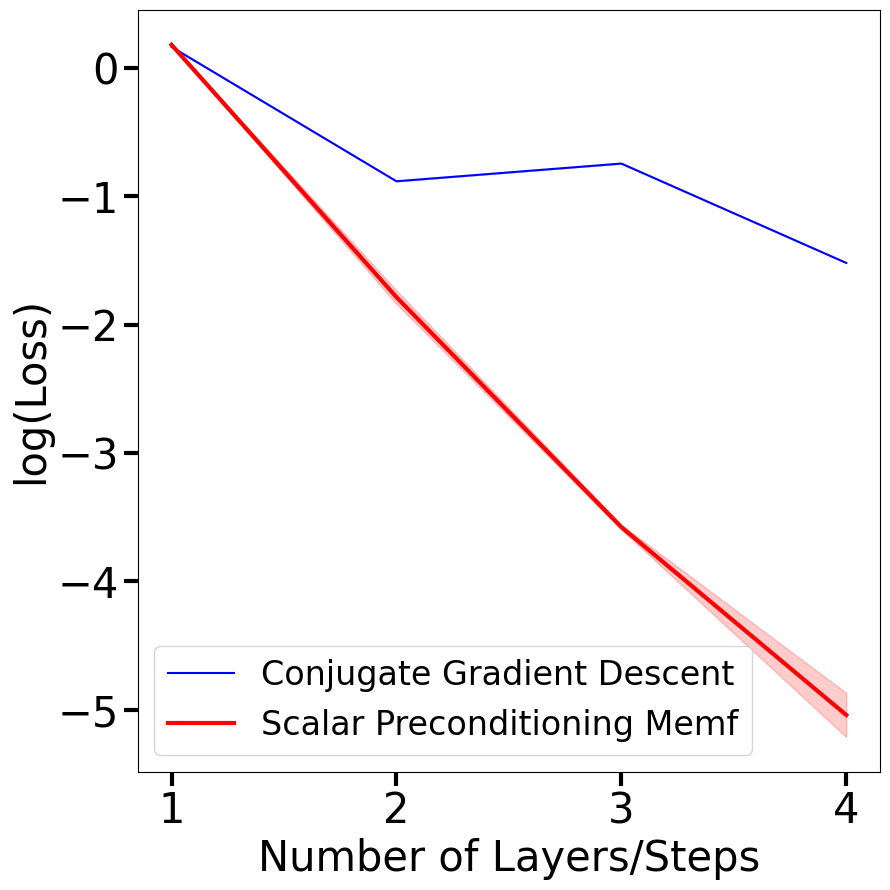

In [17]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (9, 9))

losses = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key]
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)/10

losses_zero = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_zero.keys()
for idx, key in enumerate(keys):
    losses_zero[idx,:] = loss_dict_zero[key]
losses_mean_zero = torch.mean(losses_zero, axis=0)
losses_std_zero = torch.std(losses_zero, axis=0)/10

plt.plot(n_layers, gd_loss_mean, color='blue', label='Conjugate Gradient Descent')
plt.fill_between(n_layers, gd_loss_mean - gd_loss_std/10, gd_loss_mean + gd_loss_std/10, color='blue', alpha=0.2)

ax.plot(n_layers, losses_mean, color = 'red', lw = 3, label='Scalar Preconditioning Memf')
ax.fill_between(n_layers, losses_mean-losses_std, losses_mean+losses_std, color = 'red', alpha = 0.2)

#ax.plot(n_layers, losses_mean_zero, color = 'green', lw = 3, label='Linear Transformer')
#ax.fill_between(n_layers, losses_mean_zero-losses_std_zero, losses_mean_zero+losses_std_zero, color = 'green', alpha = 0.2)

plt.ylabel('log(Loss)',fontsize=30)
plt.xlabel('Number of Layers/Steps',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
ax.legend(fontsize=24)
#ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)

In [ ]:
loss_dict

{(0,): tensor([  1.32, -28.67,   -inf, -31.88]),
 (1,): tensor([  1.32, -31.88,   -inf,   -inf]),
 (2,): tensor([  1.26, -29.69,   -inf, -31.88]),
 (3,): tensor([  1.32, -29.11,   -inf,   -inf]),
 (4,): tensor([ -6.44, -29.69,   -inf, -30.50])}

In [ ]:
gd_loss_mean

tensor([ 0.75,  0.18, -0.74, -1.62])

In [ ]:
losses_mean

tensor([ 0.86,  0.54,  0.20, -0.14])